# Preparing the Sentinel-2 Dataset for the Lake Mille Lacs Area of Interest

Author: Gregor Beyerle

Date: 2022-06-11

## Overview

This notebook contains the data preprocessing steps to fully prepare the dataset for further use in machine learning tasks. In the following sections I will:

- Load the prepared bathymetry map
- Load, clip and resample the L1C Sentinel-2 scene
- Load, clip and resample the L2A Sentinel-2 scene
- Load, clip and resample the Sentinel-2 product generated by using the Acolite processor
- Merge the intermediate EOPatches
- Save the resulting EOPatch to disk
- Inspect the resulting EOPatch

In [1]:
import os
import glob
import sys
import dotenv

from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    EOWorkflow,
    OutputTask,
    LoadTask,
    SaveTask,
    OverwritePermission,
    EOExecutor,
)
from eolearn.core.eoworkflow_tasks import InputTask
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

This notebook uses functionality of both the `eolearn_extras` module as well as the `sdb_utils` module. It is important to add the relative location of the repository's root directory to the `sys.path` and import `eolearn_extras` before `sdb_utils` as some functions in this module reference `eolearn_extras`.

In [2]:
root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.acolite import ReadAcoliteProduct
from sdb_utils.acolite import enrich_acolite_path_with_datetime_information
from sdb_utils.paths import return_product_paths_for_dt

The data for this project can - depending on whether you work with the complete dataset or only the preprocessed data - be roughly 13 GB on disk. This makes it necessary to distribute data individually from the repository and therefore the location of the data root directory might differ from setup to setup. This repository uses a `.env` file to configure the individual data root directory location. You need to add the `.env` file to your `notebooks` directory and add a line containing the needed information as a line following the pattern `data_root=<path-to-your-data-root>` in order for this notebook to work correctly.

In [3]:
dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

The following cell contains the code I use to prepare the paths of all the different satellite data products that are available to me for a given AOI. My workflow for collecting and preparing the data in this project was:

- Searching for a suitable (cloudless, well illuminated, not containing too much sun glint, no visible ice, favorable water quality conditions) using [EO Browser](https://apps.sentinel-hub.com/eo-browser)
- Acquiring the selected Sentinel-2 L1C scene from the [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home)
- Running the [Sen2Cor](https://step.esa.int/main/snap-supported-plugins/sen2cor/#:~:text=Sen2Cor%20is%20a%20processor%20for,Atmosphere%20Level%201C%20input%20data.) preprocessor as described in the Readme to acquire the L2A product
- Running the [Acolite](https://odnature.naturalsciences.be/remsem/software-and-data/acolite) preprocessor as described in the Readme to acquire a bottom of atmosphere surface reflectance or (in the best case) a bottom of atmosphere water surface reflectance product.

The way I organized the data in respect to the data root directory is documented in the repository's Readme file.

In [4]:
sentinel_archives_root = os.path.abspath(os.path.join(data_root_path, 'sentinel_mille_lacs'))
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)

l1c_products = eolx.io.get_products_by_level(sentinel_archives, 'L1C')
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')

sentinel_acolite_folder_pattern = f'{sentinel_archives_root}/*ACOLITE*'
sentinel_acolite_folders = glob.glob(sentinel_acolite_folder_pattern)
sentinel_acolite_products = [enrich_acolite_path_with_datetime_information(path) for path in sentinel_acolite_folders]

In this project I only look at a single hand-picked image acquisition. Automated picking of these scenes, creation of high quality mosaics or retrieving bathymetry estimations from acquisition time series would have exceeded the scope of this project by a fair amount.

In the following cell I select the archive locations for L1C, L2A and Acolite products for the acquisition for the given timestamp `2021-4-29T17:08:51`.

In [5]:
observation_dt_of_interest = datetime.datetime(2021, 4, 29, 17, 8, 51)
l1c_path, l2a_path, acolite_path = return_product_paths_for_dt(
    l1c_products=l1c_products,
    l2a_products=l2a_products,
    acolite_products=sentinel_acolite_products,
    dt=observation_dt_of_interest,
)

l1c_path, l2a_path, acolite_path

('D:\\sdb_datasets\\sentinel_mille_lacs\\S2A_MSIL1C_20210429T170851_N0300_R112_T15TVM_20210429T215623.SAFE',
 'D:\\sdb_datasets\\sentinel_mille_lacs\\S2A_MSIL2A_20210429T170851_N9999_R112_T15TVM_20220501T111454.SAFE',
 'D:\\sdb_datasets\\sentinel_mille_lacs\\S2A_20210429T170851_ACOLITE_SUBSET')

As the workflow should produce EOPatches in which the pixel locations of the "ground truth" bathymetry labels and the pixel locations of all available Sentinel-2 data product bands reference the (mostly) exact same place on the planet I first have to load the EOPatch holding the prepared bathymetry map for the AOI.

In [6]:
bathy_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'mille_lacs_bathy_eop')
)
load_bathy_eop = LoadTask(bathy_eop_path)
mille_lacs_bathy_eop = load_bathy_eop.execute()
mille_lacs_bathy_eop

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    buffered_bathy_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  bbox=BBox(((436481.2917158468, 5106398.21482021), (464421.2917158468, 5135108.21482021)), crs=CRS('32615'))
)

I use the bathymetry dimensions and its bounding box as the template for how the the data should be clipped and resampled. I constructed the workflow in a way that I avoid to reproject the Sentinel-2 bands as this could lead to small inconsistencies in certain edge cases. As the bathymetry map is already resampled to a 10 by 10 meter spatial resolution and the bounding box is already clipped to the desired AOI the `ReadSentinelArchive` and `ReadAcolitProduct` tasks can infer this information from as well.

In contrast to strictly linear workflows it is also possible to build more complicated workflow structures as long as they follow the form of a Directed Acyclic Graph (DAG). The eo-learn framework allows this by manually wrapping `EOTask` objects in `EONode` objects while specifying the inputs.

Because of the way I apply atmospheric correction to the L1C products the data resides on disk in the Sentinel specific Standard Archive Format for Europe (SAFE). The `ReadSentinelArchiveTask` is used to extract the specified products and make them available to the workflow. I decided to load the data in the form of unitless reflectance values instead of the digital number (DN) variant because Acolite products are presented the same way. I took this step solely to make these values more comparable in my analysis.

In [7]:
input_bathy_task = InputTask(mille_lacs_bathy_eop)
input_bathy_node = EONode(input_bathy_task, inputs=tuple())

height, width, _ = mille_lacs_bathy_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape

read_l1c_eop_task = eolx.io.ReadSentinelArchiveTask(
    target_shape=(height, width),
    bbox=mille_lacs_bathy_eop.bbox,
    digital_number_to_reflectance=True,
)
read_l1c_node = EONode(read_l1c_eop_task, inputs=tuple())

read_l2a_eop_task = eolx.io.ReadSentinelArchiveTask(
    target_shape=(height, width),
    bbox=mille_lacs_bathy_eop.bbox,
    digital_number_to_reflectance=True,
)
read_l2a_node = EONode(read_l2a_eop_task, inputs=tuple())

The Acolite preprocessor - apart from being able to work with multiple sensors from Landsat, Sentinel and commercial missions - can produce multiple output products at the same time while being extensively configurable. In this project I'm using the `L2R` (bottom of atmosphere surface reflectance) or `L2W` (bottom of atmosphere water surface reflectance). If I can not produce the `L2W` product because the processor cannot produce valid pixels for a region it does not detect as water or because overcorrection causes a high amount of negative pixel values I fall back to the `L2R` product.

In the case of the Bahamas AOI I use the `L2R` product. I specify the product and reflectance type names as I need them later for referencing the EOPatch features.

In [8]:
acolite_product = 'L2R'
reflectance_type = 'rhos'
acolite_data_feature = (FeatureType.DATA, f'{acolite_product}_data')
read_acolite_product_task = ReadAcoliteProduct(
    reference_bbox=mille_lacs_bathy_eop.bbox,
    feature=acolite_data_feature,
    acolite_product=acolite_product,
    reflectance_type=reflectance_type
)
read_acolite_node = EONode(read_acolite_product_task, inputs=tuple())

Each loading, clipping and resampling process happens in isolation. This means that each task produces its own EOPatch. We can condense this down to one by merging the patches with the `MergeEOPatchesTask`.

In [9]:
merge_patches_task = MergeEOPatchesTask()
merge_eop_node = EONode(
    merge_patches_task,
    inputs=[input_bathy_node, read_l1c_node, read_l2a_node, read_acolite_node]
)

At this point we only have to define the tasks to save the resulting EOPatch to disk and define it as an output accessible in memory. As already alluded to before the resulting workflow is a bit more involved with multiple parallel strands meeting at the merge point and branching off again. You can see a visualization below.

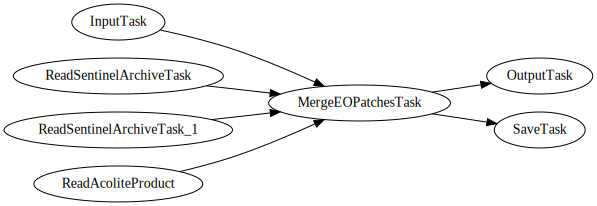

In [10]:
output_label = 'merged_output'
output_task = OutputTask(output_label)
output_node = EONode(output_task, inputs=[merge_eop_node])

output_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'mille_lacs_sentinel_merged')
)
save_eop_task = SaveTask(
    output_path,
    overwrite_permission=OverwritePermission.OVERWRITE_PATCH
)
save_eop_node = EONode(save_eop_task, inputs=[merge_eop_node])

read_merge_wf = EOWorkflow(
    [
        input_bathy_node,
        read_l1c_node,
        read_l2a_node,
        read_acolite_node,
        merge_eop_node,
        output_node,
        save_eop_node,
    ]
)

read_merge_wf.dependency_graph()

Having multiple (long running) independent tasks and still working on each task sequentially would be a waste in cases where the processing power of multiple CPU cores is available. The eo-learn framework offers a way for executing a workflow in parallel through the `EOExecutor` class. This interface also allows the parametrization of workflow nodes at execution time.

In [11]:
execution_args = {
    read_l1c_node: {'sentinel_archive_path': l1c_path},
    read_l2a_node: {'sentinel_archive_path': l2a_path},
    read_acolite_node: {'acolite_product_folder': acolite_path},
}

executor = EOExecutor(read_merge_wf, [execution_args], save_logs=True, logs_folder='../executor_logs')
read_merge_wf_res = executor.run(workers=4)

100%|██████████| 1/1 [00:48<00:00, 48.80s/it]


Looking at the resulting EOPatch we see elements in the following sections:

- data (with a time dimension)
- data_timeless
- mask_timeless
- meta_info
- bbox
- timestamp

We are already aware of the timeless data, the timeless mask and the bbox because it originates from the prepared bathymetry data. In contrast to the timeless data the Sentinel-2 scenes we are using are explicitly connected to a point in time (expanding the shape of the underlying dataset to the form `point-in-time x height x width x channels`). In this project I don't make use of the time dimensions so this distinction is less important. The timestamp collection in the EOPatch would correspond with the `point-in-time` dimension. We can see in this case that we would expect one timestamp but get two. This is caused by an inconsistency I am experiencing with the data products resulting from using the Acolite processor. For this project this bug can be ignored but it warrants further exploration and development efforts for future work.

The meta info collection can hold arbitrary information (as long as it is JSON serializable). In this project I use this space to make note of the source mission of the Sentinel-2 scene (Sentinel-2A/Sentinel-2B) and the amount of overcorrected pixels per band for the Acolite product.

In [12]:
mille_lacs_merged_eop = read_merge_wf_res[0].outputs[output_label]
mille_lacs_merged_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=float32)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=float32)
    L2R_data: numpy.ndarray(shape=(1, 2871, 2794, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    buffered_bathy_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  meta_info={
    acolite_overcorrection_info: <class 'dict'>, length=11
    mission: 'S2A'
  }
  bbox=BBox(((436481.2917158468, 5106398.21482021), (464421.2917158468, 5135108.21482021)), crs=CRS('32615'))
  timestamp=[datetime.datetime(2021, 4, 29, 17, 8, 51), datetime.datetime(2021, 4, 29, 17, 20, 49)]
)

Inspecting the meta information further reveals that for the chosen Acolite product there are many pixels in almost all bands that got overcorrected. As I set every overcorrected pixel to zero to avoid negative reflectance values a small amount of pixels would not impact subsequent modelling efforts which is unfortunately not the case for this AOI. In contrast to the other AOIs I was not able to find an Acolite configuration that would yield usable results. While I am confident that a more sophisticated Acolite user with a stronger background in atmospheric correction could have produced a favorable result, this would have exceeded my resources and the scope of this project.

In [13]:
mille_lacs_merged_eop.meta_info['acolite_overcorrection_info']

{'L2R_data_rhos_443': 95953,
 'L2R_data_rhos_492': 9126,
 'L2R_data_rhos_560': 277,
 'L2R_data_rhos_665': 29762,
 'L2R_data_rhos_704': 41464,
 'L2R_data_rhos_740': 149648,
 'L2R_data_rhos_783': 81246,
 'L2R_data_rhos_833': 80082,
 'L2R_data_rhos_865': 126517,
 'L2R_data_rhos_1614': 141608,
 'L2R_data_rhos_2202': 10992}

The images below show the true color representation of the L1C, L2A and Acolite products for the given AOI. While the visual representation is very open to interpretation of the respective analyst we can still gain some intuition from this form of visualization.

One of the takeaways from this AOI in particular is that in contrast to Puerto Rico and the Bahamas the ground visibility and water conditions are visibly poorer.

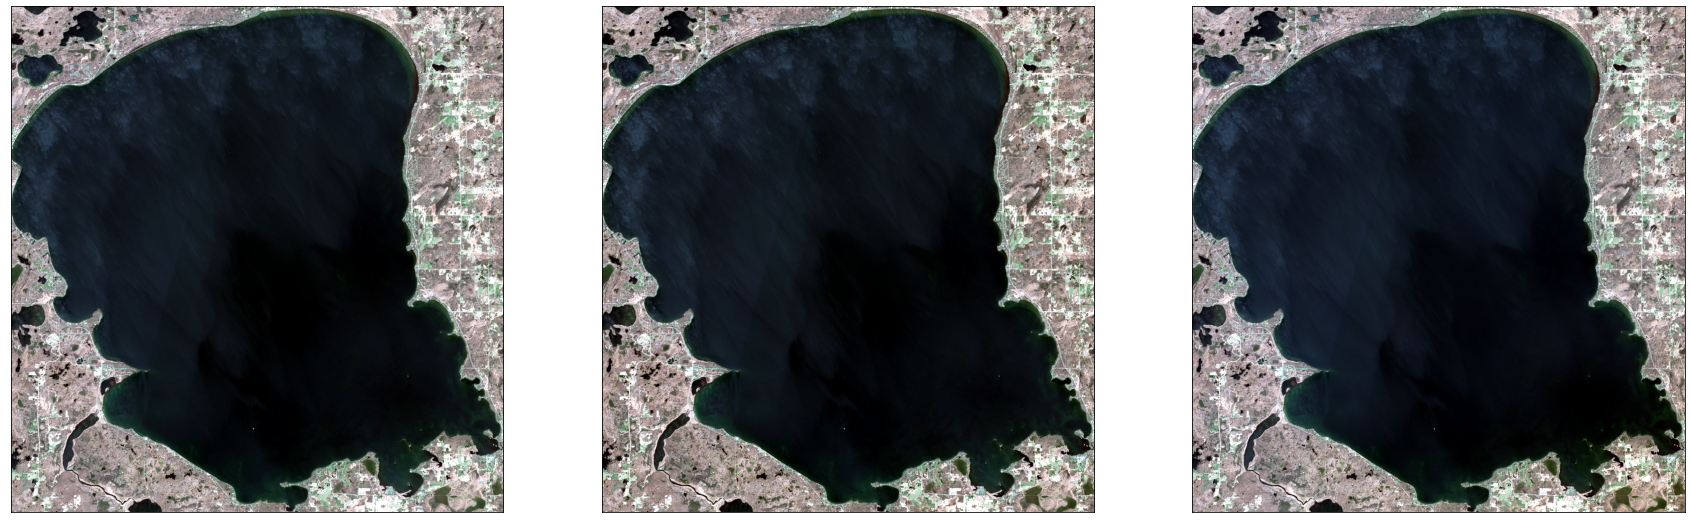

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 40))

eolx.visualization.plot_eopatch(
    mille_lacs_merged_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L1C_data"),
    stretch=True,
    ax=ax1,
)

eolx.visualization.plot_eopatch(
    mille_lacs_merged_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2A_data"),
    stretch=True,
    ax=ax2,
)

eolx.visualization.plot_eopatch(
    mille_lacs_merged_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2R_data"),
    stretch=True,
    ax=ax3,
)

plt.show()

Another way to inspect the impact of different processing levels we can also inspect the histograms of certain bands. Depending the exact configuration the Stumpf Log-Regression method (Stumpf et al., 2003),which I use as the baseline model in this project, potentially uses the red, blue and green bands, so it makes sense to inspect the value distribution in these bands. We can see that depending on the processing method the distributions of these bands show noticeable differences.

The histograms are visibly narrower than for the other AOIs with less distinction between the bands. I clipped the histograms at a reflectance value of 0.101 because otherwise the the differences would be even less visible.

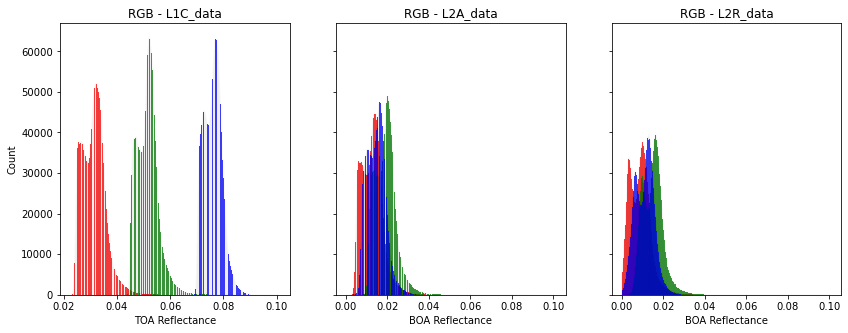

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 5), sharey=True)
mask_feature = (FeatureType.MASK_TIMELESS, 'buffered_bathy_mask')

eolx.visualization.plot_band_histogram_rgb(
    mille_lacs_merged_eop, (FeatureType.DATA, "L1C_data"),
    mask_feature=mask_feature,
    ax=ax1, xlabel='TOA Reflectance',
    clip_value=0.101
)
eolx.visualization.plot_band_histogram_rgb(
    mille_lacs_merged_eop, (FeatureType.DATA, "L2A_data"),
    mask_feature=mask_feature,
    ax=ax2, xlabel='BOA Reflectance',
    clip_value=0.101
)
eolx.visualization.plot_band_histogram_rgb(
    mille_lacs_merged_eop, (FeatureType.DATA, f"{acolite_product}_data"),
    mask_feature=mask_feature,
    ax=ax3, xlabel='BOA Reflectance',
    clip_value=0.101
)

plt.show()